# **Simulating admissions to the intensive care unit at a large medical center, wait times, and evaluating the impact of a triage system**

# Problem.



*   Many hospitals are experiencing ICU overcrowding, with demand often exceeding available beds. This leads to longer wait times for critically ill patients needing intensive care.
*   The problem this work attempts to address is the challenge of optimizing ICU operations to improve patient outcomes and maximize the utilization of limited resources.
*   ICUs often face critical situations where the demand for beds and medical attention surpasses availability (eg, what happened during covid), leading to delays in treatment for critically ill patients. This can increase patient wait times, affect treatment outcomes, and strain healthcare systems, especially during peak periods or health crises.
*   Using a discrete event simulation model approach that incorporates a triage system, I explored how to prioritize patients based on the severity of their conditions, thereby ensuring that those in greatest need receive timely care.
*   This can help develop a better understanding of how different prioritization methods affect ICU dynamics, which can inform policies and protocols to enhance the efficiency and effectiveness of critical care services.  

# Process flowchart of patient flow in and out of the ICU
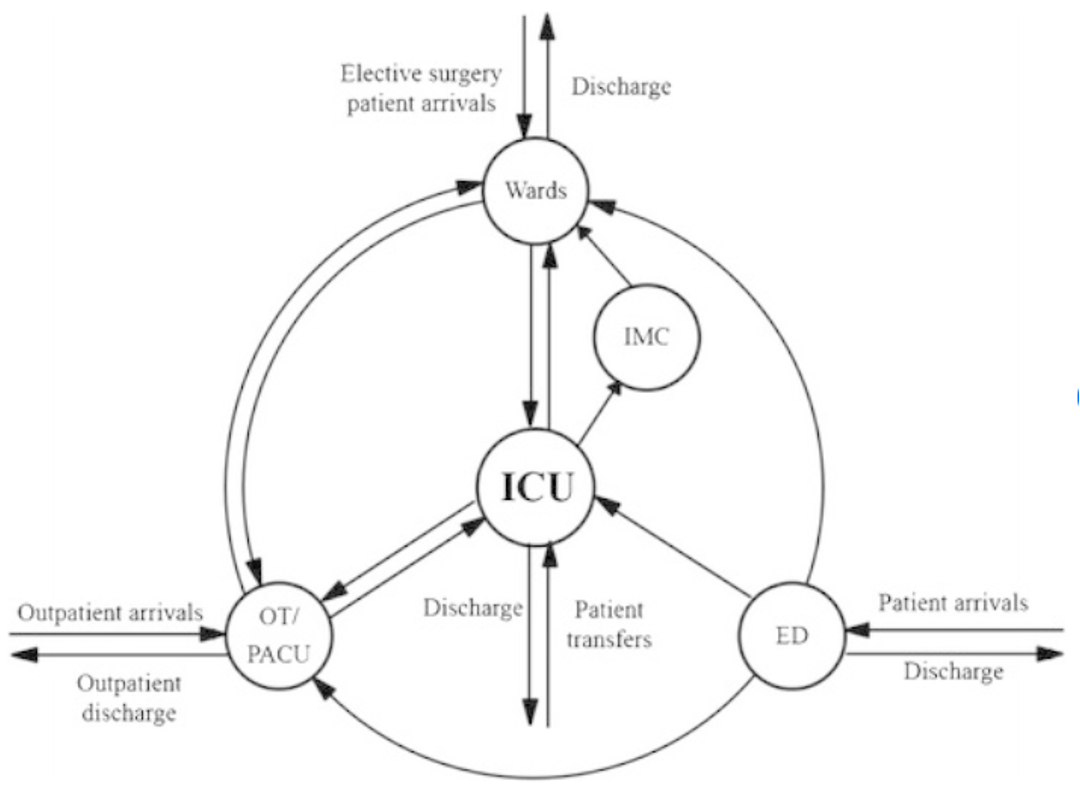

# Chosen dataset

I have chosen the MIMIC database, which is from the BIDMC hospital in Boston, MA. Data were collected between 2001-2012 and focused on ICU patients.

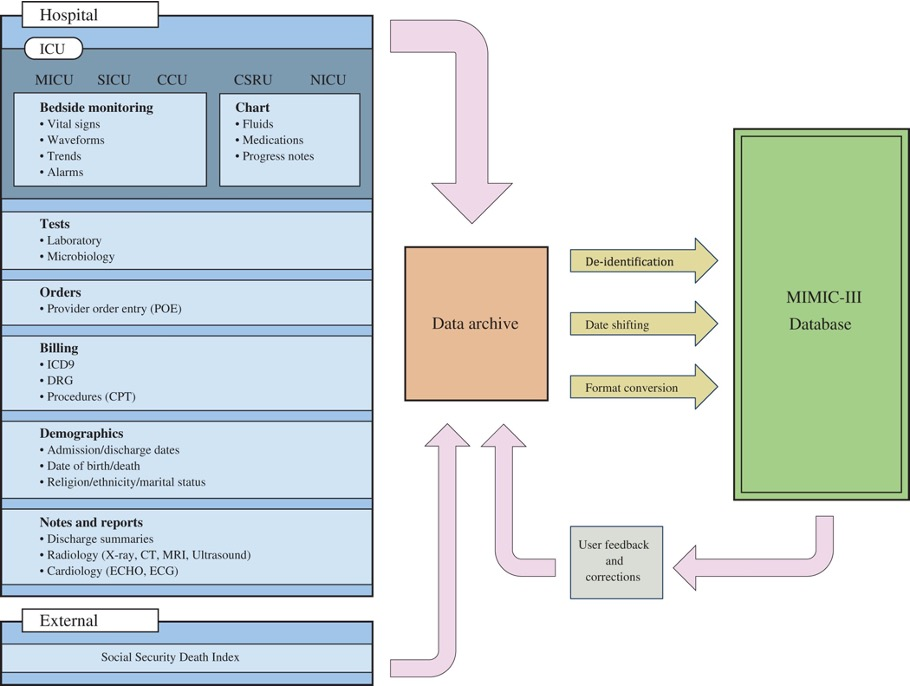

It is worth noting that the BIDMC has a 77-bed ICU.



# Challenges

*   Some files were too large, and I had to limit the data used to 200 million rows
(especially for the CHARTEVENT table from the relational dataset). I took this into account when merging the relevant data points needed to conduct this work.
*   The dataset assigned random dates of admission/discharge to avoid revealing any identifiable patient information. But this caused the admission dates to range from 2100 to 2210. I did find a way to avoid relying on this admission date when calculating the admission durations and other metrics.

# Discrete event simulation model.


*   The model is designed to simulate the flow of patients through an ICU to analyze resource allocation and patient wait times.
*   Covers a one-year operational period of an ICU  Utilizes a stochastic process to model the random arrival of patients to the ICU (since this has an unpredictable nature)
*   Incorporates exponential distribution to assign treatment times  Manages a fixed number of ICU beds (77 beds) focusing on BIDMC
*   Performance indicators include patient wait times and ICU bed occupancy rates to assess operational efficiency
*   I have also incorporated the factors of ICU admission rates as well as ICU discharge rates (drawn from the data; ie, validated).

In [2]:
# Install SimPy if not already installed
!pip install simpy

In [3]:
# Import necessary libraries
import simpy
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

In [ ]:

# Load the preprocessed data
admissions = pd.read_csv('/content/ADMISSIONS.csv')
icustays = pd.read_csv('/content/ICUSTAYS.csv')
patients = pd.read_csv('/content/PATIENTS.csv')
callout = pd.read_csv('/content/CALLOUT.csv')
transfers = pd.read_csv('/content/TRANSFERS.csv')
chartevents_sample = pd.read_csv('/content/CHARTEVENTS_sample.csv')

# Verify the data loading
print("Admissions data shape:", admissions.shape)
print("ICU stays data shape:", icustays.shape)
print("Patients data shape:", patients.shape)
print("Chart events data shape:", chartevents_sample.shape)
print("Callout data shape:", callout.shape)
print("Transfers data shape:", transfers.shape)

Admissions data shape: (58976, 19)
ICU stays data shape: (61532, 12)
Patients data shape: (46520, 8)
Chart events data shape: (20000000, 15)
Callout data shape: (34499, 24)
Transfers data shape: (261897, 13)


Data management and processing

In [ ]:
# Merge Relevant Tables
merged_data = pd.merge(admissions, icustays, on=['SUBJECT_ID', 'HADM_ID'])
merged_data = pd.merge(merged_data, patients, on='SUBJECT_ID')

In [ ]:
# Handle Missing Values
merged_data = merged_data.dropna(subset=['ADMITTIME', 'DISCHTIME', 'INTIME', 'OUTTIME'])

In [ ]:
# Convert Time Columns to Datetime
merged_data['ADMITTIME'] = pd.to_datetime(merged_data['ADMITTIME'])
merged_data['DISCHTIME'] = pd.to_datetime(merged_data['DISCHTIME'])
merged_data['INTIME'] = pd.to_datetime(merged_data['INTIME'])
merged_data['OUTTIME'] = pd.to_datetime(merged_data['OUTTIME'])

Simulation

In [ ]:
NUM_BEDS = 10
SIM_TIME = 1000  # Total simulation time
ARRIVAL_RATE = 0.5  # Average arrival rate of patients
TREATMENT_TIME_MEAN = 10  # Average treatment time in ICU

patient_wait_times = []
patient_treatment_times = []

def patient(env, name, icu):
    arrival_time = env.now
    with icu.request() as request:
        yield request
        wait_time = env.now - arrival_time
        patient_wait_times.append(wait_time)

        treatment_time = random.expovariate(1 / TREATMENT_TIME_MEAN)
        patient_treatment_times.append(treatment_time)

        yield env.timeout(treatment_time)

env = simpy.Environment()
icu = simpy.Resource(env, capacity=NUM_BEDS)

def patient_generator(env, icu):
    i = 0
    while True:
        yield env.timeout(random.expovariate(1 / ARRIVAL_RATE))
        env.process(patient(env, f'Patient {i+1}', icu))
        i += 1

env.process(patient_generator(env, icu))
env.run(until=SIM_TIME)

Analysis and visualization

In [ ]:
# Analyze and Visualize Results
avg_wait_time = sum(patient_wait_times) / len(patient_wait_times)
avg_treatment_time = sum(patient_treatment_times) / len(patient_treatment_times)
print(f'Average wait time: {avg_wait_time:.2f}')
print(f'Average treatment time: {avg_treatment_time:.2f}')

Average wait time: 242.66
Average treatment time: 9.99


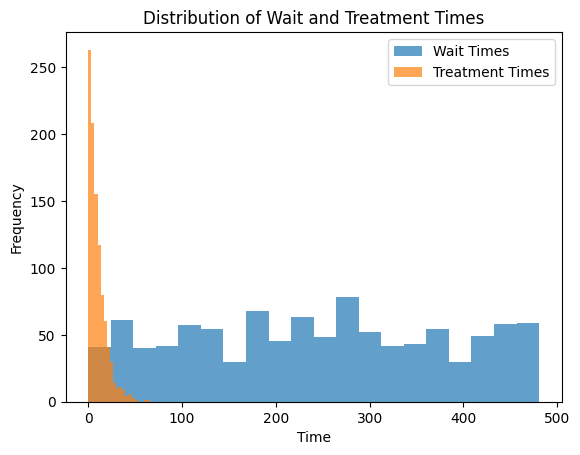

In [ ]:
# Generate Graphs
plt.hist(patient_wait_times, bins=20, alpha=0.7, label='Wait Times')
plt.hist(patient_treatment_times, bins=20, alpha=0.7, label='Treatment Times')
plt.legend(loc='upper right')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Distribution of Wait and Treatment Times')
plt.show()

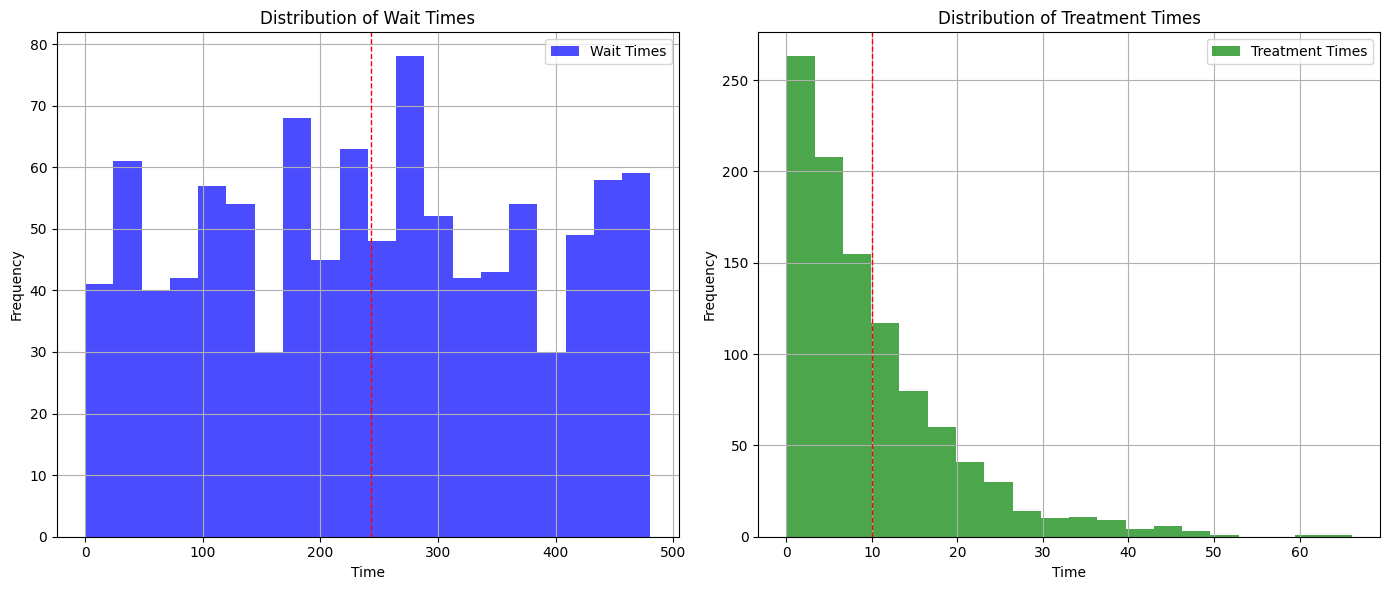

In [ ]:
# Generate Histograms for Wait Times and Treatment Times
plt.figure(figsize=(14, 6))

# Histogram for Wait Times
plt.subplot(1, 2, 1)
plt.hist(patient_wait_times, bins=20, alpha=0.7, color='blue', label='Wait Times')
plt.axvline(avg_wait_time, color='red', linestyle='dashed', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Distribution of Wait Times')
plt.legend()
plt.grid(True)

# Histogram for Treatment Times
plt.subplot(1, 2, 2)
plt.hist(patient_treatment_times, bins=20, alpha=0.7, color='green', label='Treatment Times')
plt.axvline(avg_treatment_time, color='red', linestyle='dashed', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Distribution of Treatment Times')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# The MIMIC III data is from the ICUs at Beth Israel Deaconess Medical Center (BIDMC), and there are 77 beds in the ICU units in BIDMC in Boston, MA.
# And I will calculate the average time spent in the ICU for a patient to incorporate that into the model.



In [ ]:
import pandas as pd

# Load the ICUSTAYS.csv file
icustays = pd.read_csv('/content/ICUSTAYS.csv')

# Convert INTIME and OUTTIME to datetime format
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])
icustays['OUTTIME'] = pd.to_datetime(icustays['OUTTIME'])

# Calculate the duration of each ICU stay in hours
icustays['ICU_DURATION_HOURS'] = (icustays['OUTTIME'] - icustays['INTIME']).dt.total_seconds() / 3600

# Calculate the average ICU stay duration
average_icu_stay_duration = icustays['ICU_DURATION_HOURS'].mean()

print(f'The average time a patient spends in the ICU at Beth Israel Deaconess Medical Center (BIDMC) is {average_icu_stay_duration:.2f} hours.')


The average time a patient spends in the ICU at Beth Israel Deaconess Medical Center (BIDMC) is 118.03 hours.


In [ ]:
# Adding more time units to the calculation:

# Calculate the duration of each ICU stay
icustays['ICU_DURATION'] = icustays['OUTTIME'] - icustays['INTIME']

# ICU_DURATION in seconds
icustays['ICU_DURATION_SECONDS'] = icustays['ICU_DURATION'].dt.total_seconds()

# ICU_DURATION in minutes
icustays['ICU_DURATION_MINUTES'] = icustays['ICU_DURATION_SECONDS'] / 60

# ICU_DURATION in hours
icustays['ICU_DURATION_HOURS'] = icustays['ICU_DURATION_SECONDS'] / 3600

# ICU_DURATION in days
icustays['ICU_DURATION_DAYS'] = icustays['ICU_DURATION_SECONDS'] / 86400

# Calculate the average ICU stay duration in different units
average_icu_stay_duration_seconds = icustays['ICU_DURATION_SECONDS'].mean()
average_icu_stay_duration_minutes = icustays['ICU_DURATION_MINUTES'].mean()
average_icu_stay_duration_hours = icustays['ICU_DURATION_HOURS'].mean()
average_icu_stay_duration_days = icustays['ICU_DURATION_DAYS'].mean()

print(f'The average time a patient spends in the ICU at BIDMC is {average_icu_stay_duration_seconds:.2f} seconds.')
print(f'The average time a patient spends in the ICU at BIDMC is {average_icu_stay_duration_minutes:.2f} minutes.')
print(f'The average time a patient spends in the ICU at BIDMC is {average_icu_stay_duration_hours:.2f} hours.')
print(f'The average time a patient spends in the ICU at BIDMC is {average_icu_stay_duration_days:.2f} days.')

The average time a patient spends in the ICU at BIDMC is 424912.71 seconds.
The average time a patient spends in the ICU at BIDMC is 7081.88 minutes.
The average time a patient spends in the ICU at BIDMC is 118.03 hours.
The average time a patient spends in the ICU at BIDMC is 4.92 days.


But how do I know what is the rate of patients admitted to the ICU from this database? Are all patients in this database ICU patients, or only some of them? Is there a way to calculate the rate of ICU admissions?

To asnwer that, I am going to dig a little deeper into the ICUSTAYS table and the ADMISSIONS table, and see if I can find the needed information needed to calculate the rate of ICU admissions.

I would also want to see what could be associated with a higher rate of ICU admissions in these patients. This could help me with the simulation model to see what can be modified to optimize the patient flow in and out of the ICU.

In [ ]:
# Load the ICUSTAYS and ADMISSIONS tables
icustays = pd.read_csv('/content/ICUSTAYS.csv')
admissions = pd.read_csv('/content/ADMISSIONS.csv')

# Display the first few rows of each table to understand their structure
print(icustays.head())
print(admissions.head())


   ROW_ID  SUBJECT_ID  HADM_ID  ICUSTAY_ID DBSOURCE FIRST_CAREUNIT  \
0     365         268   110404      280836  carevue           MICU   
1     366         269   106296      206613  carevue           MICU   
2     367         270   188028      220345  carevue            CCU   
3     368         271   173727      249196  carevue           MICU   
4     369         272   164716      210407  carevue            CCU   

  LAST_CAREUNIT  FIRST_WARDID  LAST_WARDID               INTIME  \
0          MICU            52           52  2198-02-14 23:27:38   
1          MICU            52           52  2170-11-05 11:05:29   
2           CCU            57           57  2128-06-24 15:05:20   
3          SICU            52           23  2120-08-07 23:12:42   
4           CCU            57           57  2186-12-25 21:08:04   

               OUTTIME     LOS  
0  2198-02-18 05:26:11  3.2490  
1  2170-11-08 17:46:57  3.2788  
2  2128-06-27 12:32:29  2.8939  
3  2120-08-10 00:39:04  2.0600  
4  2186-12-

In [ ]:
# Count the number of ICU admissions
num_icu_admissions = icustays['ICUSTAY_ID'].nunique()

# Count the number of hospital admissions
num_hospital_admissions = admissions['HADM_ID'].nunique()

# Calculate the rate of ICU admissions
icu_admission_rate = num_icu_admissions / num_hospital_admissions

print(f'Number of ICU admissions: {num_icu_admissions}')
print(f'Number of hospital admissions: {num_hospital_admissions}')
print(f'Rate of ICU admissions: {icu_admission_rate:.4f}')


Number of ICU admissions: 61532
Number of hospital admissions: 58976
Rate of ICU admissions: 1.0433


Calculating admissions rate

In [ ]:
# Convert ADMITTIME to datetime format
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])

# Determine the earliest and latest admission times
earliest_admission = admissions['ADMITTIME'].min()
latest_admission = admissions['ADMITTIME'].max()

# Calculate the total time span in days
total_time_span_days = (latest_admission - earliest_admission).days

print(f'Earliest admission: {earliest_admission}')
print(f'Latest admission: {latest_admission}')
print(f'Total time span (days): {total_time_span_days}')

# Total number of admissions
total_admissions = len(admissions)

# Calculate average daily admissions
average_daily_admissions = total_admissions / total_time_span_days

# Convert daily rate to hourly rate (assuming 24-hour operations)
hourly_arrival_rate = average_daily_admissions / 24

print(f'Total number of admissions: {total_admissions}')
print(f'Average daily admissions: {average_daily_admissions:.2f}')
print(f'Hourly arrival rate: {hourly_arrival_rate:.2f}')

# Update ARRIVAL_RATE based on the calculation
ARRIVAL_RATE = hourly_arrival_rate

# Print the updated ARRIVAL_RATE
print(f'Updated ARRIVAL_RATE: {ARRIVAL_RATE:.2f}')

Earliest admission: 2100-06-07 19:59:00
Latest admission: 2210-08-17 17:13:00
Total time span (days): 40246
Total number of admissions: 58976
Average daily admissions: 1.47
Hourly arrival rate: 0.06
Updated ARRIVAL_RATE: 0.06


# Updating the model

Simulation parameters

In [ ]:
# Set the number of ICU beds to 77 and use the calculated average ICU stay duration
NUM_BEDS = 77
SIM_TIME = 1000  # Total simulation time
TREATMENT_TIME_MEAN = 119.77  # Use the calculated average ICU stay duration

In [ ]:
# Initialize lists to store simulation data
patient_wait_times = []
patient_treatment_times = []
icu_occupancy = []  # List to track ICU occupancy over time

Definitions

In [ ]:
# Define the patient process
def patient(env, name, icu):
    arrival_time = env.now
    with icu.request() as request:
        yield request
        wait_time = env.now - arrival_time
        patient_wait_times.append(wait_time)

        treatment_time = random.expovariate(1 / TREATMENT_TIME_MEAN)
        patient_treatment_times.append(treatment_time)

        yield env.timeout(treatment_time)

# Define the ICU occupancy tracking process
def track_icu_occupancy(env, icu):
    while True:
        icu_occupancy.append(icu.count)
        yield env.timeout(1)  # Check occupancy every time unit

# Initialize the simulation environment
env = simpy.Environment()
icu = simpy.Resource(env, capacity=NUM_BEDS)

# Define the patient generator process
def patient_generator(env, icu):
    i = 0
    while True:
        yield env.timeout(random.expovariate(1 / ARRIVAL_RATE))
        env.process(patient(env, f'Patient {i+1}', icu))
        i += 1

# Start the patient generator and occupancy tracker processes
env.process(patient_generator(env, icu))
env.process(track_icu_occupancy(env, icu))

<Process(track_icu_occupancy) object at 0x7e9cc43b3640>

Run the sim

In [ ]:
# Run the simulation
env.run(until=SIM_TIME)

Analysis and visualizataion

Average wait time: 436.11
Average treatment time: 122.01


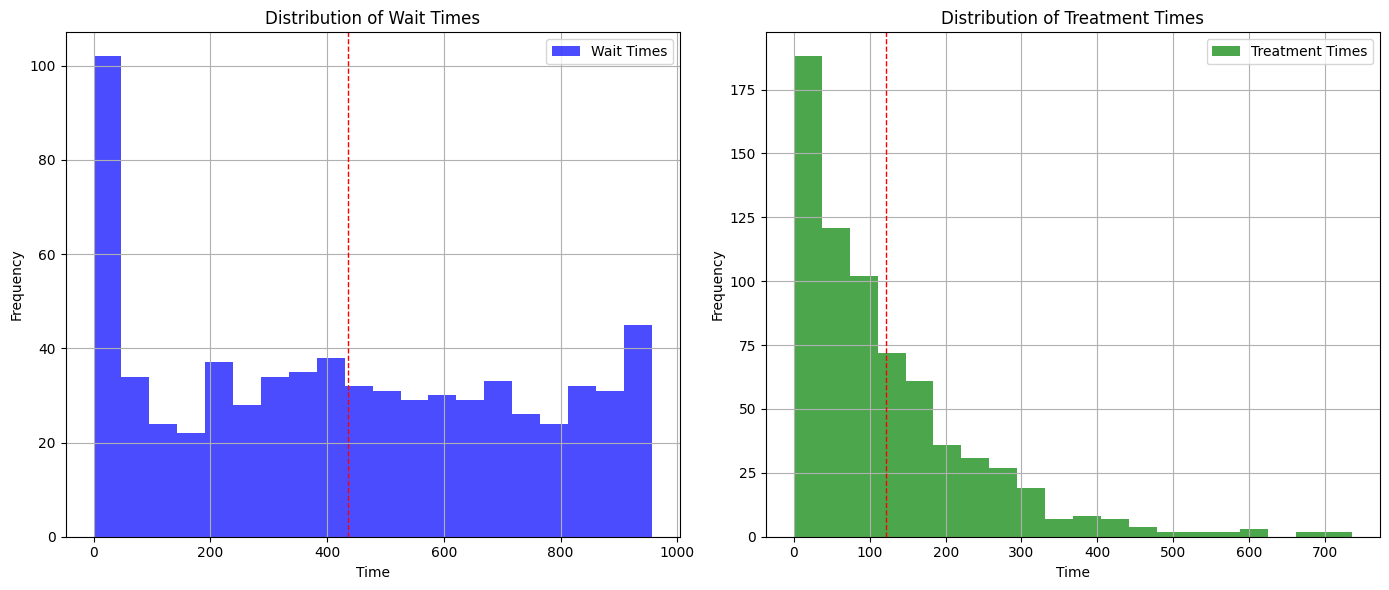

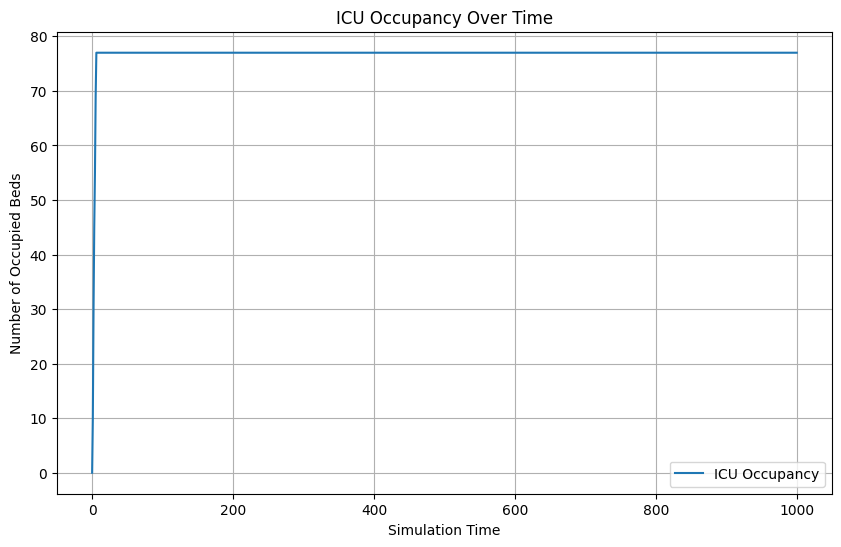

In [ ]:
# Analyze and Visualize Results
avg_wait_time = sum(patient_wait_times) / len(patient_wait_times)
avg_treatment_time = sum(patient_treatment_times) / len(patient_treatment_times)
print(f'Average wait time: {avg_wait_time:.2f}')
print(f'Average treatment time: {avg_treatment_time:.2f}')

# Generate Histograms for Wait Times and Treatment Times
plt.figure(figsize=(14, 6))

# Histogram for Wait Times
plt.subplot(1, 2, 1)
plt.hist(patient_wait_times, bins=20, alpha=0.7, color='blue', label='Wait Times')
plt.axvline(avg_wait_time, color='red', linestyle='dashed', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Distribution of Wait Times')
plt.legend()
plt.grid(True)

# Histogram for Treatment Times
plt.subplot(1, 2, 2)
plt.hist(patient_treatment_times, bins=20, alpha=0.7, color='green', label='Treatment Times')
plt.axvline(avg_treatment_time, color='red', linestyle='dashed', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Distribution of Treatment Times')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Time series plot for ICU Occupancy
plt.figure(figsize=(10, 6))
plt.plot(range(SIM_TIME), icu_occupancy, label='ICU Occupancy')
plt.xlabel('Simulation Time')
plt.ylabel('Number of Occupied Beds')
plt.title('ICU Occupancy Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Let's check how the ICU occupancy over time would be if we have a range of possible values for each of: ICU capacity & Arrival rate

In [ ]:
# Define ranges for ICU capacity and arrival rates
icu_capacities = [50, 75, 100, 125, 150]  # Different ICU capacities
arrival_rates = [0.05, 0.1, 0.2, 0.3, 0.4]  # Different hourly arrival rates

# Simulation parameters
SIM_TIME = 1000  # Total simulation time in hours
TREATMENT_TIME_MEAN = 119.77  # Use the calculated average ICU stay duration in hours

In [ ]:
# Function to run the simulation for given parameters
def run_simulation(icu_capacity, arrival_rate):
    env = simpy.Environment()
    icu = simpy.Resource(env, capacity=icu_capacity)
    patient_wait_times = []
    patient_treatment_times = []
    icu_occupancy = []

    def patient(env, name, icu):
        arrival_time = env.now
        with icu.request() as request:
            yield request
            wait_time = env.now - arrival_time
            patient_wait_times.append(wait_time)
            treatment_time = random.expovariate(1 / TREATMENT_TIME_MEAN)
            patient_treatment_times.append(treatment_time)
            yield env.timeout(treatment_time)

    def track_icu_occupancy(env, icu):
        while True:
            icu_occupancy.append(icu.count)
            yield env.timeout(1)  # Check occupancy every time unit

    def patient_generator(env, icu):
        i = 0
        while True:
            yield env.timeout(random.expovariate(1 / arrival_rate))
            env.process(patient(env, f'Patient {i+1}', icu))
            i += 1

    env.process(patient_generator(env, icu))
    env.process(track_icu_occupancy(env, icu))
    env.run(until=SIM_TIME)

    return icu_occupancy


In [ ]:
# Run simulations and store results
results = {}

for icu_capacity in icu_capacities:
    for arrival_rate in arrival_rates:
        icu_occupancy = run_simulation(icu_capacity, arrival_rate)
        results[(icu_capacity, arrival_rate)] = icu_occupancy

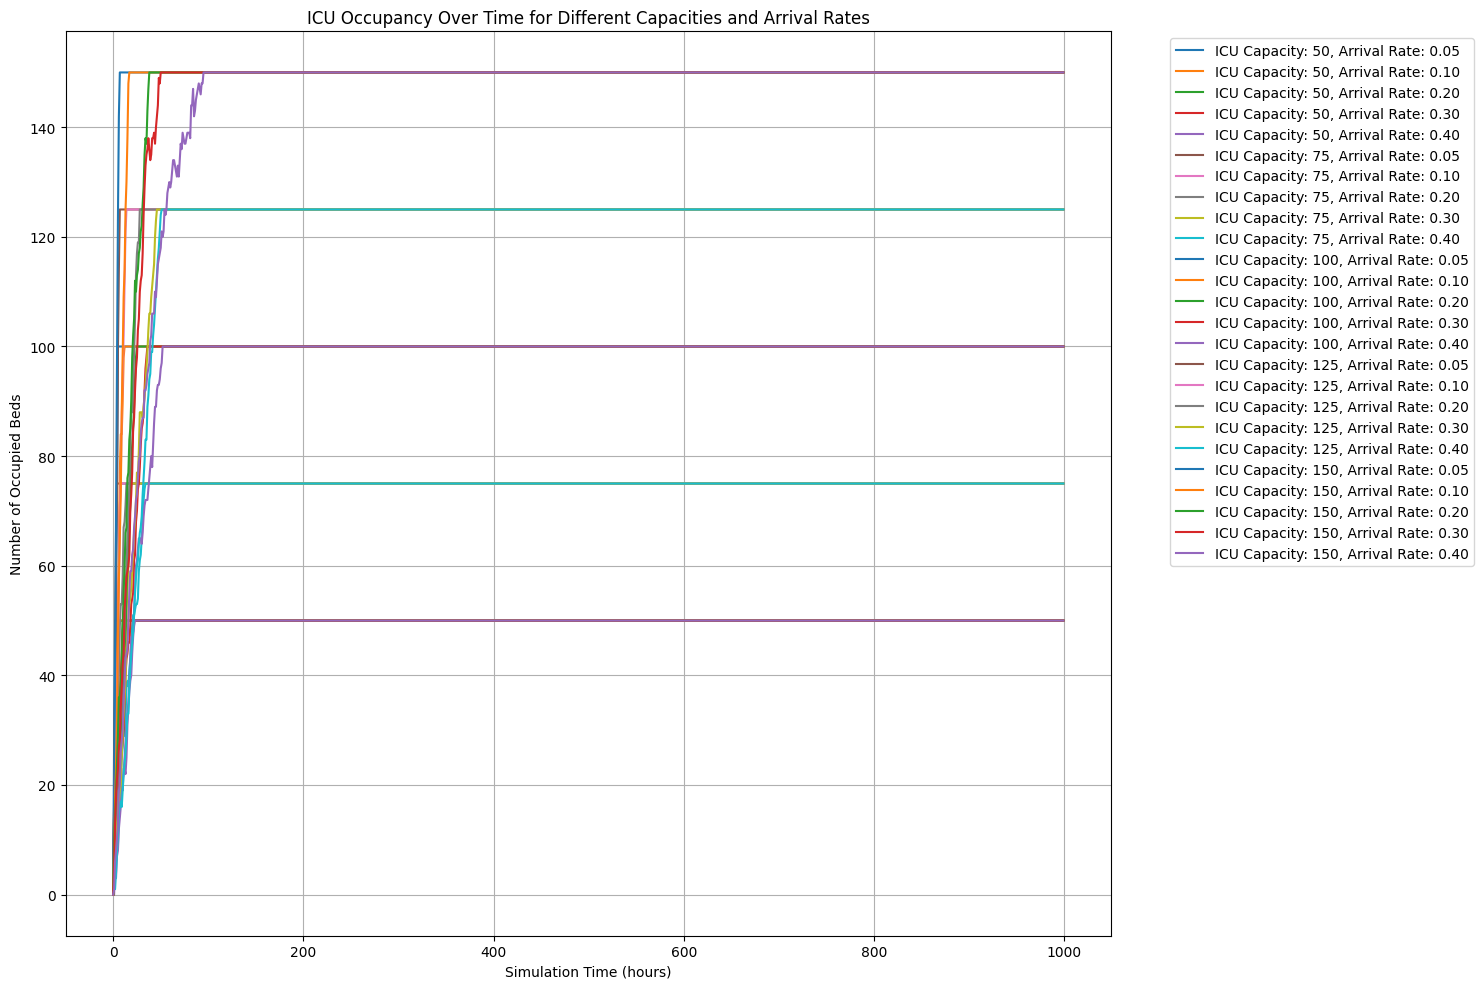

In [ ]:
# Plot the results
plt.figure(figsize=(15, 10))

for icu_capacity in icu_capacities:
    for arrival_rate in arrival_rates:
        icu_occupancy = results[(icu_capacity, arrival_rate)]
        plt.plot(range(SIM_TIME), icu_occupancy, label=f'ICU Capacity: {icu_capacity}, Arrival Rate: {arrival_rate:.2f}')

plt.xlabel('Simulation Time (hours)')
plt.ylabel('Number of Occupied Beds')
plt.title('ICU Occupancy Over Time for Different Capacities and Arrival Rates')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

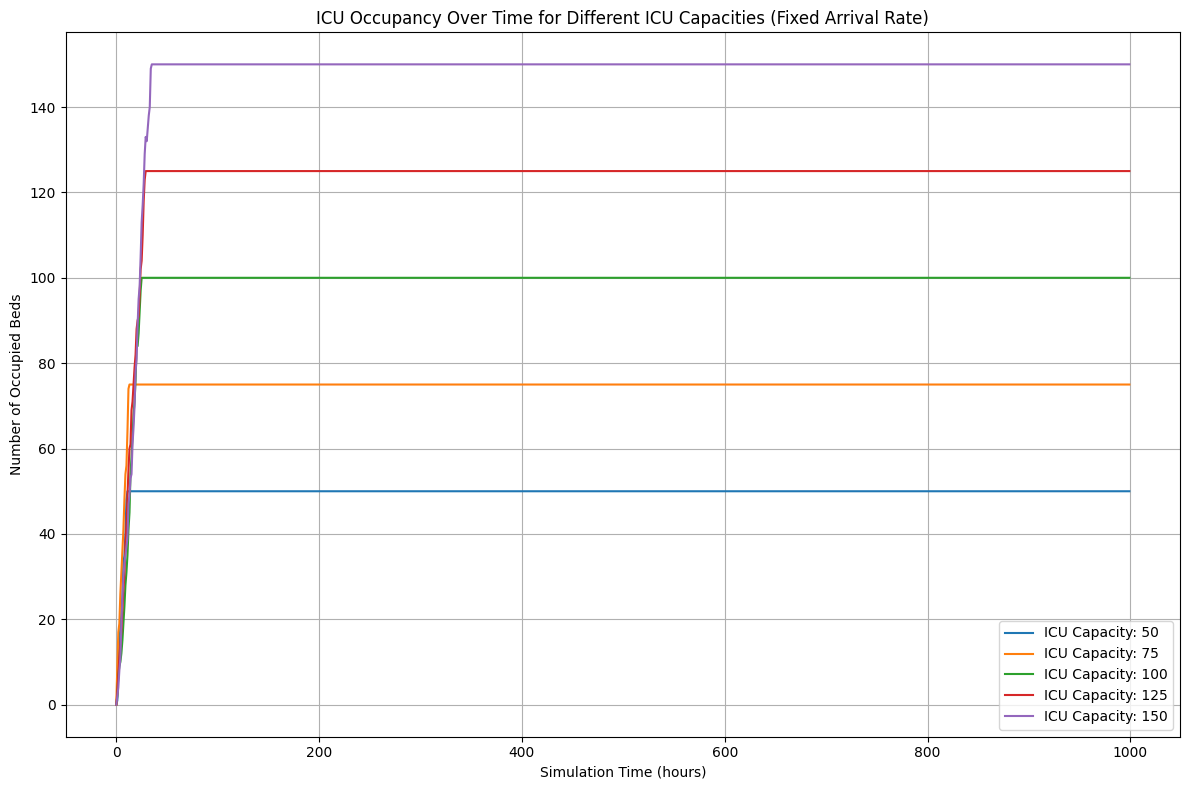

In [ ]:
# Plot ICU Occupancy Over Time for Different ICU Capacities
plt.figure(figsize=(12, 8))

for icu_capacity in icu_capacities:
    icu_occupancy = run_simulation(icu_capacity, arrival_rates[2])  # Use a fixed arrival rate
    plt.plot(range(SIM_TIME), icu_occupancy, label=f'ICU Capacity: {icu_capacity}')

plt.xlabel('Simulation Time (hours)')
plt.ylabel('Number of Occupied Beds')
plt.title('ICU Occupancy Over Time for Different ICU Capacities (Fixed Arrival Rate)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

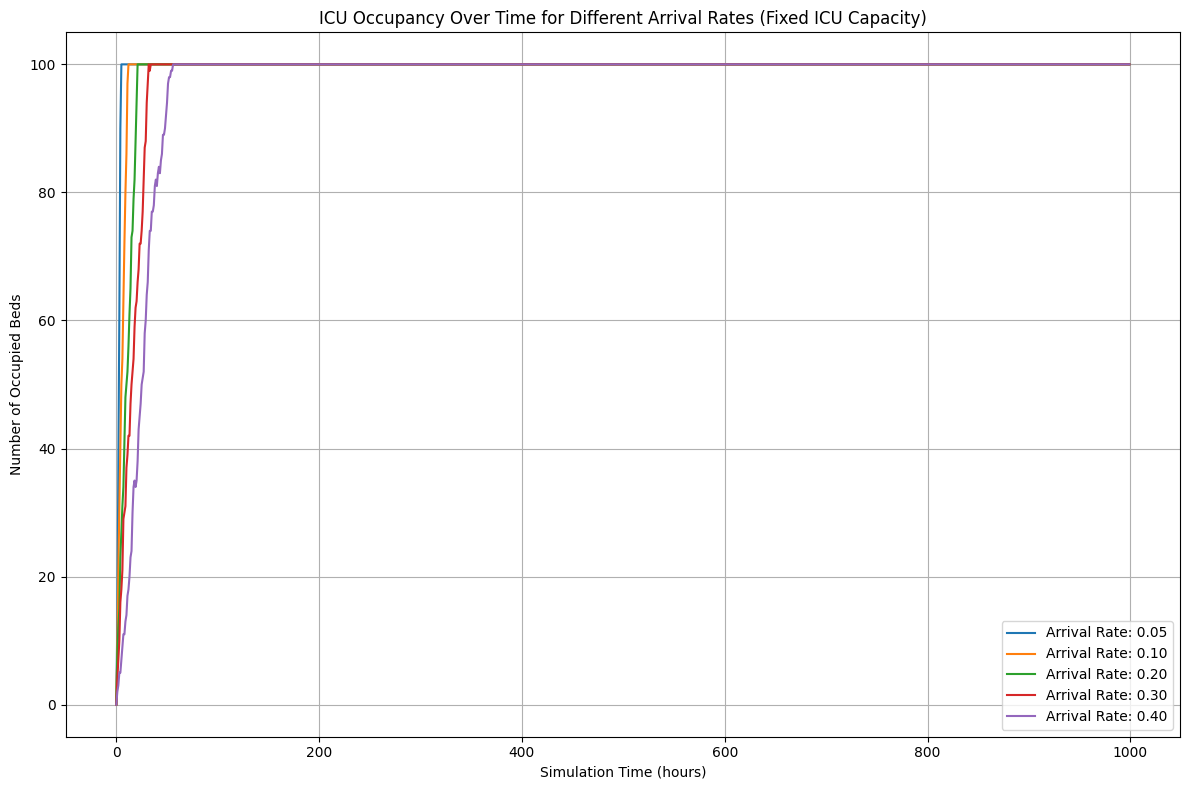

In [ ]:
# Plot ICU Occupancy Over Time for Different Arrival Rates
plt.figure(figsize=(12, 8))

for arrival_rate in arrival_rates:
    icu_occupancy = run_simulation(icu_capacities[2], arrival_rate)  # Use a fixed ICU capacity
    plt.plot(range(SIM_TIME), icu_occupancy, label=f'Arrival Rate: {arrival_rate:.2f}')

plt.xlabel('Simulation Time (hours)')
plt.ylabel('Number of Occupied Beds')
plt.title('ICU Occupancy Over Time for Different Arrival Rates (Fixed ICU Capacity)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

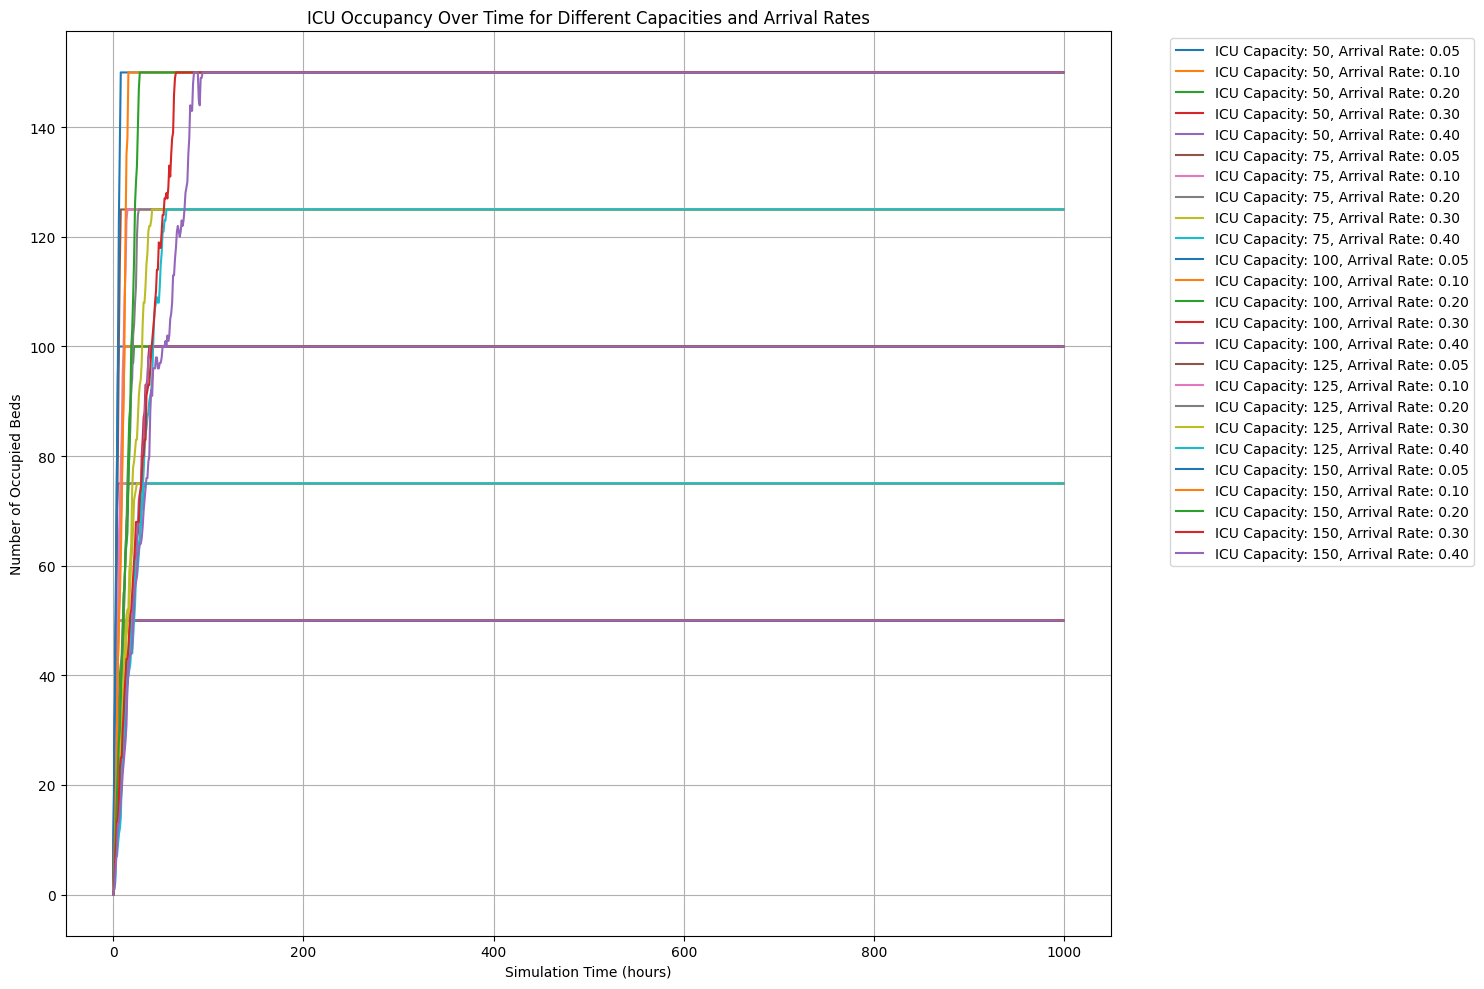

In [ ]:
# Plot Combined Graph with Improved Readability
plt.figure(figsize=(15, 10))

for icu_capacity in icu_capacities:
    for arrival_rate in arrival_rates:
        icu_occupancy = run_simulation(icu_capacity, arrival_rate)
        plt.plot(range(SIM_TIME), icu_occupancy, label=f'ICU Capacity: {icu_capacity}, Arrival Rate: {arrival_rate:.2f}')

plt.xlabel('Simulation Time (hours)')
plt.ylabel('Number of Occupied Beds')
plt.title('ICU Occupancy Over Time for Different Capacities and Arrival Rates')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


# What about discharge from the ICU? I have not factored that in yet. I am going to evaluate the ICU discharges trends within the timeframe recorded within the MIMIC dataset already before factoring the results in the model.

In [ ]:
# Load the ICUSTAYS.csv file
icustays = pd.read_csv('/content/ICUSTAYS.csv')

In [ ]:
# Convert INTIME and OUTTIME to datetime format
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])
icustays['OUTTIME'] = pd.to_datetime(icustays['OUTTIME'])

# Extract discharge times
icustays['DISCHARGE_DATE'] = icustays['OUTTIME'].dt.date

# Count the number of discharges per day
discharge_counts = icustays['DISCHARGE_DATE'].value_counts().sort_index()

# Convert the series to a DataFrame for easier plotting
discharge_counts = discharge_counts.reset_index()
discharge_counts.columns = ['Date', 'Discharges']
discharge_counts = discharge_counts.sort_values('Date')

In [ ]:
# Check the minimum and maximum dates in the INTIME and OUTTIME columns
print(f"Min INTIME: {icustays['INTIME'].min()}, Max INTIME: {icustays['INTIME'].max()}")
print(f"Min OUTTIME: {icustays['OUTTIME'].min()}, Max OUTTIME: {icustays['OUTTIME'].max()}")


Min INTIME: 2100-06-07 20:00:22, Max INTIME: 2210-08-18 12:34:24
Min OUTTIME: 2100-06-08 14:59:31, Max OUTTIME: 2210-08-20 18:35:13


## NOTE: The date ranges from 2100 to 2210 are expected for the MIMIC-III dataset due to the anonymization process used to protect patient privacy.

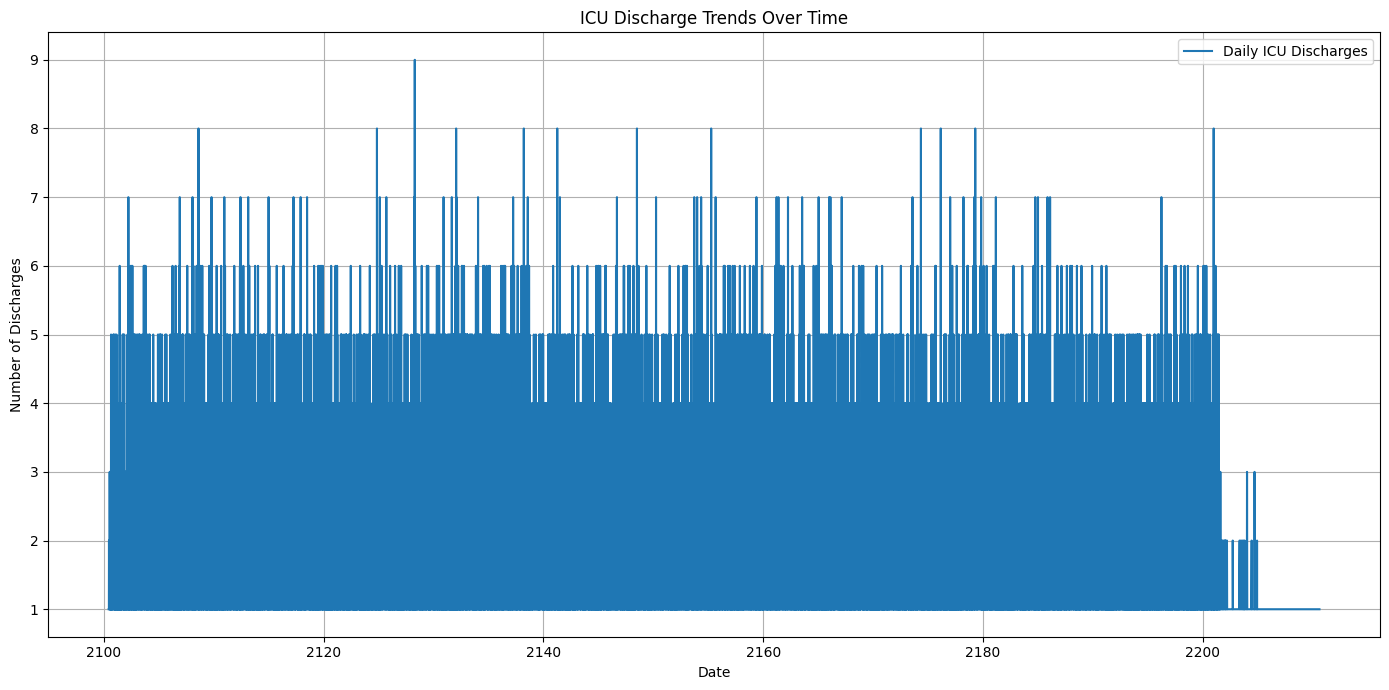

In [ ]:
# Plot discharge trends over time
plt.figure(figsize=(14, 7))
plt.plot(discharge_counts['Date'], discharge_counts['Discharges'], label='Daily ICU Discharges')
plt.xlabel('Date')
plt.ylabel('Number of Discharges')
plt.title('ICU Discharge Trends Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## NOTE: The date ranges from 2100 to 2210 are expected for the MIMIC-III dataset due to the anonymization process used to protect patient privacy.

And this is important because I cannot rely on the date range of the data, since it is an artificial range of 110 years used to obscure the patient identifiable information that is date-related.

Now, plotting both the admissions and discharges from the ICUs within the time frame of this study

In [ ]:
# Extract admission and discharge dates
icustays['ADMISSION_DATE'] = icustays['INTIME'].dt.date
icustays['DISCHARGE_DATE'] = icustays['OUTTIME'].dt.date

# Count the number of admissions and discharges per day
admission_counts = icustays['ADMISSION_DATE'].value_counts().sort_index()
discharge_counts = icustays['DISCHARGE_DATE'].value_counts().sort_index()

# Convert the series to DataFrames for easier plotting
admission_counts = admission_counts.reset_index()
admission_counts.columns = ['Date', 'Admissions']
admission_counts = admission_counts.sort_values('Date')

discharge_counts = discharge_counts.reset_index()
discharge_counts.columns = ['Date', 'Discharges']
discharge_counts = discharge_counts.sort_values('Date')

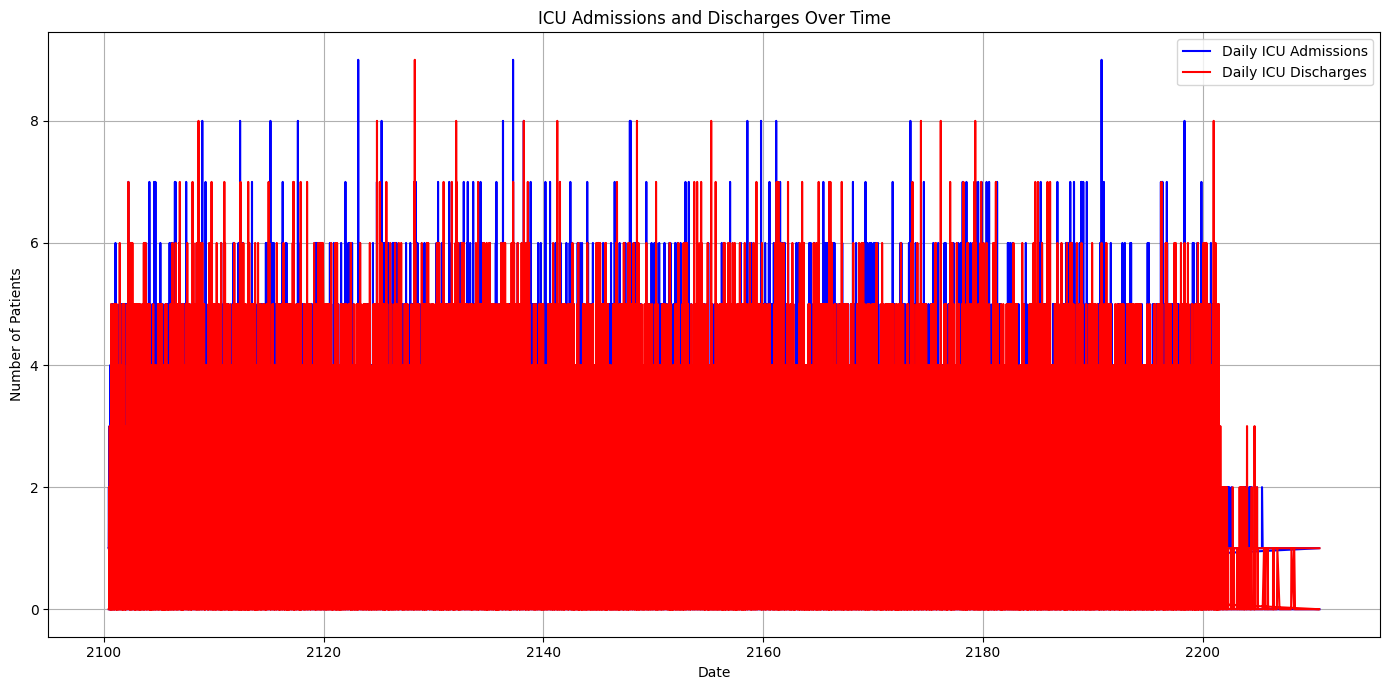

In [ ]:
# Merge the two dataframes on the Date column to align them
combined_counts = pd.merge(admission_counts, discharge_counts, on='Date', how='outer')
combined_counts = combined_counts.fillna(0)  # Fill any NaN values with 0

# Plot admission and discharge trends over time
plt.figure(figsize=(14, 7))
plt.plot(combined_counts['Date'], combined_counts['Admissions'], label='Daily ICU Admissions', color='blue')
plt.plot(combined_counts['Date'], combined_counts['Discharges'], label='Daily ICU Discharges', color='red')
plt.xlabel('Date')
plt.ylabel('Number of Patients')
plt.title('ICU Admissions and Discharges Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Going back to the simulation, now with adding the ICU discharge factor as a parameter into the simulation model:

In [ ]:
# Load the ADMISSIONS.csv file
admissions = pd.read_csv('/content/ADMISSIONS.csv')

# Total number of admissions
total_admissions = len(admissions)

# Convert ADMITTIME to datetime format
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])

# Determine the earliest and latest admission times
earliest_admission = admissions['ADMITTIME'].min()
latest_admission = admissions['ADMITTIME'].max()

# Calculate the total time span in days
# Time span from 2001 to 2012 is 11 years
time_span_days = 11 * 365  # Approximating to 365 days per year
time_span_hours = time_span_days * 24

# Calculate average daily admissions
average_daily_admissions = total_admissions / time_span_days

# Convert daily rate to hourly rate (assuming 24-hour operations)
hourly_arrival_rate = average_daily_admissions / 24

print(f'Total number of admissions: {total_admissions}')
print(f'Average daily admissions: {average_daily_admissions:.2f}')
print(f'Hourly arrival rate: {hourly_arrival_rate:.2f}')

Total number of admissions: 58976
Average daily admissions: 14.69
Hourly arrival rate: 0.61


In [ ]:
# Set parameters based on calculated values and known data
NUM_BEDS = 77
ARRIVAL_RATE = hourly_arrival_rate
TREATMENT_TIME_MEAN = 119.77  # Mean ICU stay duration
SIM_TIME = 8760  # Simulation time for one year in hours


The arrival rate is based on actual data collection spanning 11 years, converted to an hourly rate.

The simulation covers one year, reflecting typical ICU operations and avoiding the unreal date range problem.



In [ ]:
# Define the simulation function
def run_simulation(icu_capacity, arrival_rate, sim_time):
    env = simpy.Environment()
    icu = simpy.Resource(env, capacity=icu_capacity)
    icu_occupancy = []

    def patient(env, icu):
        with icu.request() as request:
            yield request
            yield env.timeout(random.expovariate(1 / TREATMENT_TIME_MEAN))

    def patient_generator(env, icu):
        while True:
            yield env.timeout(random.expovariate(1 / arrival_rate))
            env.process(patient(env, icu))

    def track_icu_occupancy(env, icu):
        while True:
            icu_occupancy.append(icu.count)
            yield env.timeout(1)  # Check occupancy every hour

    env.process(patient_generator(env, icu))
    env.process(track_icu_occupancy(env, icu))
    env.run(until=sim_time)

    return icu_occupancy


In [ ]:
# Run the simulation
icu_occupancy = run_simulation(NUM_BEDS, ARRIVAL_RATE, SIM_TIME)

Average wait time: 419.74
Average treatment time: 117.58


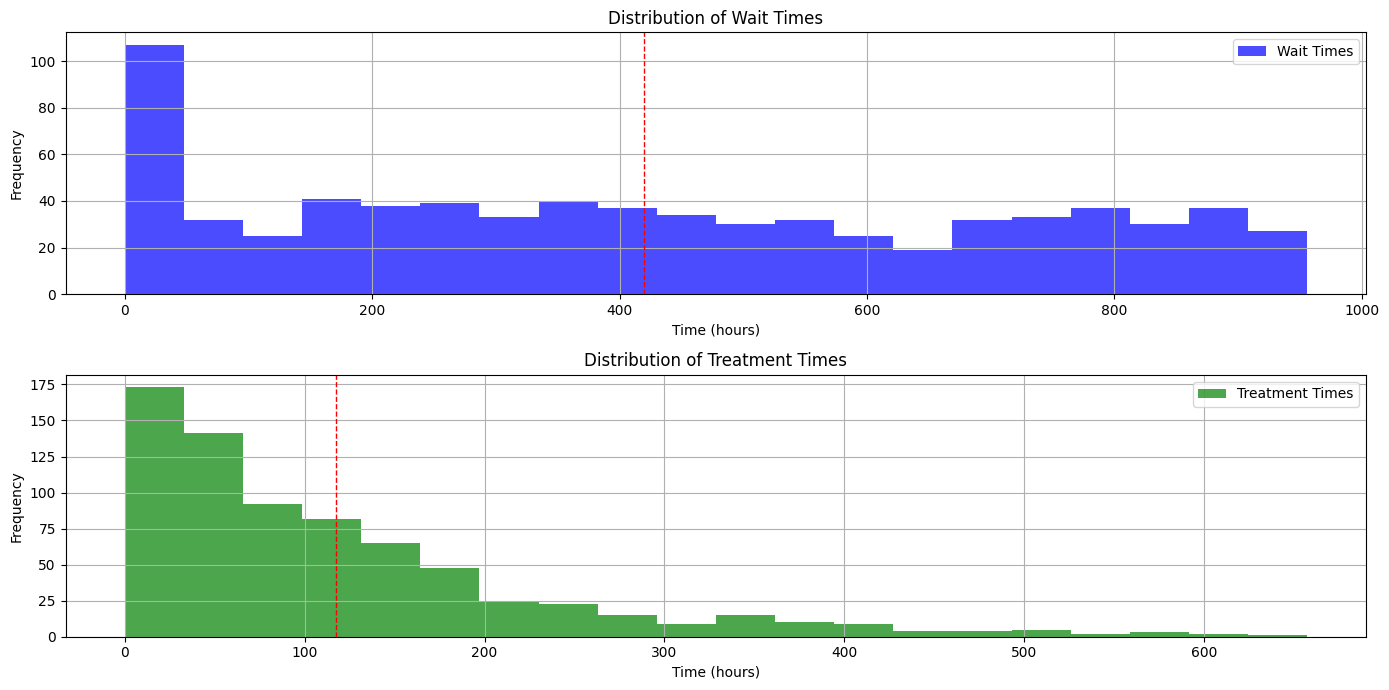

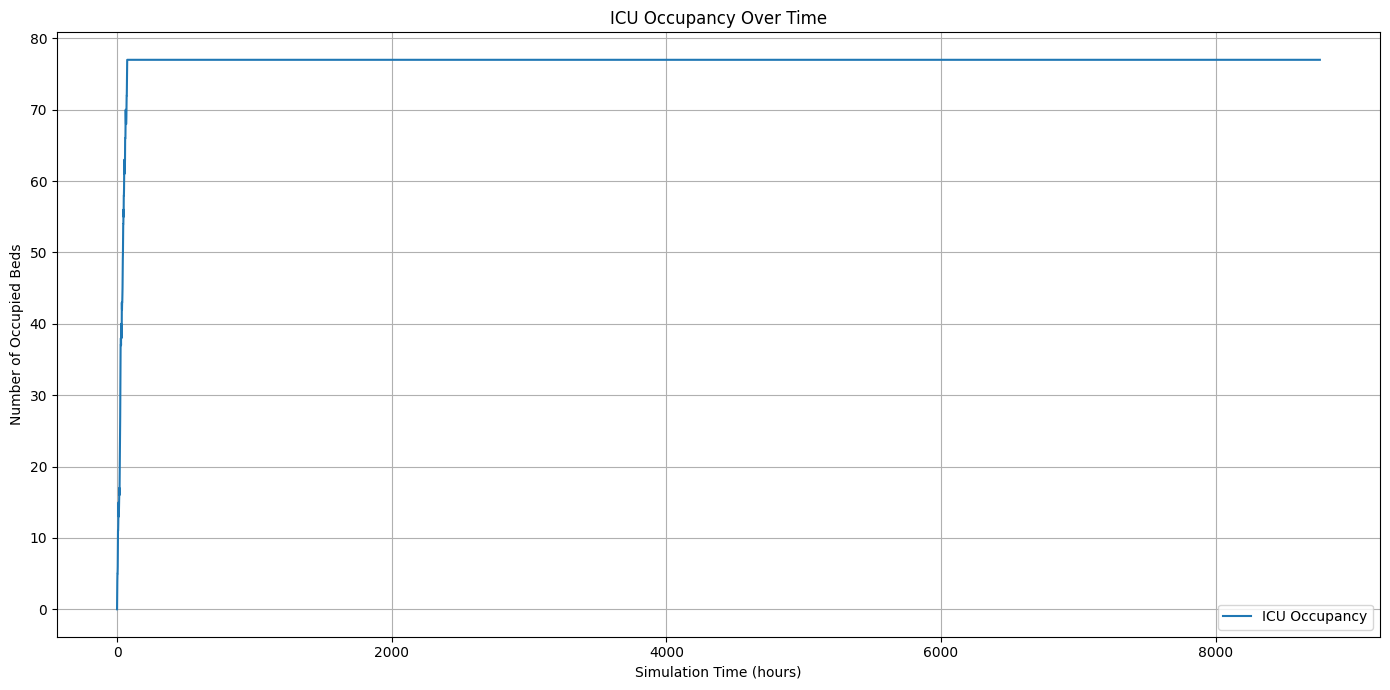

In [ ]:
# Analyze and Visualize Results
avg_wait_time = sum(patient_wait_times) / len(patient_wait_times)
avg_treatment_time = sum(patient_treatment_times) / len(patient_treatment_times)
print(f'Average wait time: {avg_wait_time:.2f}')
print(f'Average treatment time: {avg_treatment_time:.2f}')

# Plot the results
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.hist(patient_wait_times, bins=20, alpha=0.7, color='blue', label='Wait Times')
plt.axvline(avg_wait_time, color='red', linestyle='dashed', linewidth=1)
plt.xlabel('Time (hours)')
plt.ylabel('Frequency')
plt.title('Distribution of Wait Times')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.hist(patient_treatment_times, bins=20, alpha=0.7, color='green', label='Treatment Times')
plt.axvline(avg_treatment_time, color='red', linestyle='dashed', linewidth=1)
plt.xlabel('Time (hours)')
plt.ylabel('Frequency')
plt.title('Distribution of Treatment Times')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Time series plot for ICU Occupancy
plt.figure(figsize=(14, 7))
plt.plot(range(SIM_TIME), icu_occupancy, label='ICU Occupancy')
plt.xlabel('Simulation Time (hours)')
plt.ylabel('Number of Occupied Beds')
plt.title('ICU Occupancy Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

he average treatment time of approximately 118 hours (~5 days) is quite reasonable.

The histogram of wait times suggests that there is a wide distribution, with most patients not needing to wait much, while some patients experiencing very long wait times.

One thing I know from an ICU physician at the BIDMC is that they (as other ICUs do also) use a triage system to allocate the ICU beds to the patients most in need. Patients are triaged based on the severity of their condition.

# I am going to create a similar triage system to govern how patients are admitted to the ICU, so that the use of the available ICU beds is optimized.

In [33]:
random.seed(42)  # or any other integer
np.random.seed(42)

# Simulation parameters
NUM_BEDS = 77
# SIM_TIME = 8760  # One year in hours
SIM_TIME = 720  # One month in hours
TREATMENT_TIME_MEAN = 119.77  # Average treatment time in hours

# Define priorities
HIGH_PRIORITY = 0
MEDIUM_PRIORITY = 1
LOW_PRIORITY = 2
priority_distribution = {HIGH_PRIORITY: 0.1, MEDIUM_PRIORITY: 0.3, LOW_PRIORITY: 0.6}

In [34]:
# Initialize tracking for patient counts and ICU occupancy
patient_counts = {0: 0, 1: 0, 2: 0}
icu_occupancy_by_priority = {0: 0, 1: 0, 2: 0}
occupancy_over_time = {0: [], 1: [], 2: []}

In [35]:
# Function to handle patient arrivals and treatment
def patient(env, name, icu, priority):
    arrival_time = env.now
    with icu.request(priority=priority) as req:
        yield req
        # Update patient counts and occupancy when patient starts treatment
        patient_counts[priority] += 1
        icu_occupancy_by_priority[priority] += 1
        for p in occupancy_over_time:
            occupancy_over_time[p].append(icu_occupancy_by_priority[p])
        wait_time = env.now - arrival_time
        wait_times[priority].append(wait_time)
        treatment_time = random.expovariate(1 / TREATMENT_TIME_MEAN)
        yield env.timeout(treatment_time)
        # Update occupancy when patient completes treatment
        icu_occupancy_by_priority[priority] -= 1

# Function to generate patients with priorities
def patient_generator(env, icu):
    patient_id = 0
    while True:
        priority = np.random.choice([0, 1, 2], p=list(priority_distribution.values()))
        patient_id += 1
        env.process(patient(env, f'Patient{patient_id}', icu, priority))
        next_arrival = random.expovariate(1 / 0.06)
        yield env.timeout(next_arrival)

# Function to run the simulation
def run_simulation(num_beds, sim_time):
    global patient_counts, occupancy_over_time  # Declare global if needed
    env = simpy.Environment()
    icu = simpy.PriorityResource(env, capacity=num_beds)
    patient_counts = {0: 0, 1: 0, 2: 0}  # Reset counts at the start of the simulation
    occupancy_over_time = {0: [], 1: [], 2: []}
    env.process(patient_generator(env, icu))
    env.run(until=sim_time)
    return patient_counts, occupancy_over_time

In [36]:
# Run the simulation
patient_counts, occupancy_over_time = run_simulation(NUM_BEDS, SIM_TIME)

In [37]:
# Print patient counts
print("Patient counts by priority:")
for priority, count in patient_counts.items():
    print(f"Priority {priority}: {count} patients")

Patient counts by priority:
Priority 0: 488 patients
Priority 1: 28 patients
Priority 2: 41 patients


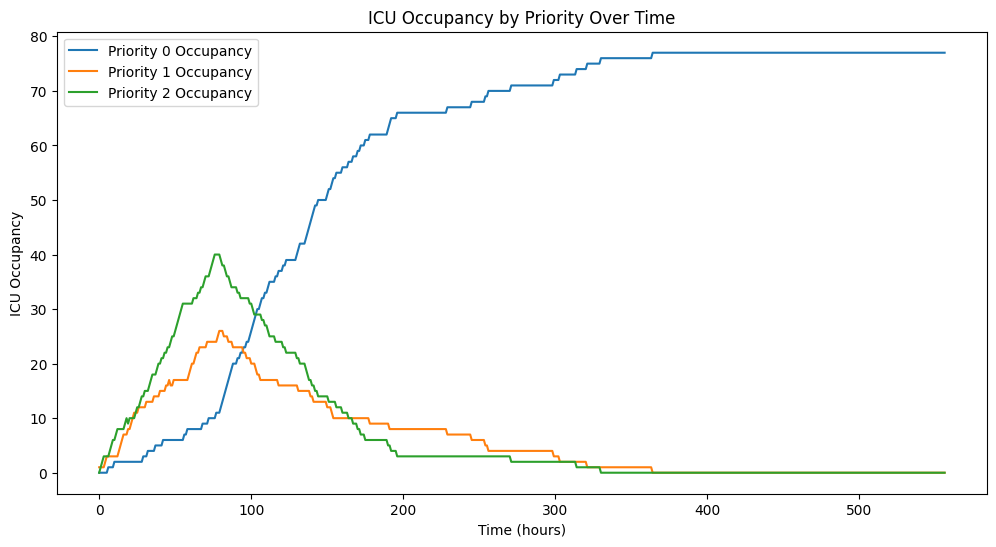

In [38]:
# Plotting ICU occupancy over time for each priority
plt.figure(figsize=(12, 6))
times = list(range(len(occupancy_over_time[0])))  # Assuming equal lengths for simplicity
for p in occupancy_over_time:
    plt.plot(times, occupancy_over_time[p], label=f'Priority {p} Occupancy')
plt.xlabel('Time (hours)')
plt.ylabel('ICU Occupancy')
plt.title('ICU Occupancy by Priority Over Time')
plt.legend()
plt.show()

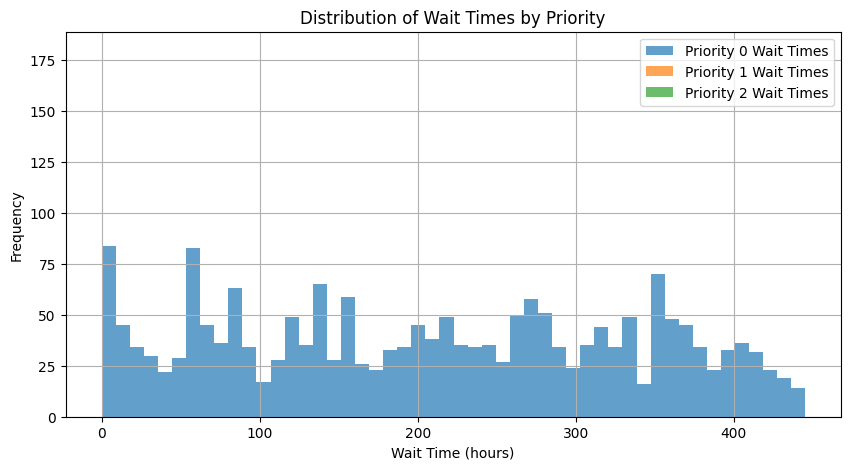

In [39]:
# Analyze and visualize results
plt.figure(figsize=(10, 5))
for priority, times in results.items():
    plt.hist(times, bins=50, alpha=0.7, label=f'Priority {priority} Wait Times')
plt.xlabel('Wait Time (hours)')
plt.ylabel('Frequency')
plt.title('Distribution of Wait Times by Priority')
plt.legend()
plt.grid(True)
plt.show()

Average wait time for Priority 0: 208.91 hours
Average wait time for Priority 1: 0.00 hours
Average wait time for Priority 2: 0.00 hours


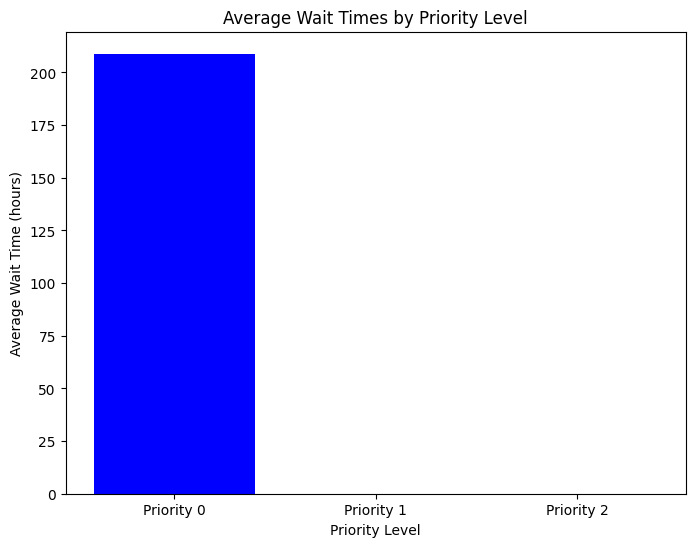

In [40]:
# Assuming 'results' is your dictionary with priorities as keys and list of wait times as values
average_wait_times = {}
for priority, times in results.items():
    if times:  # Ensure there are times recorded to avoid division by zero
        average_wait_times[priority] = sum(times) / len(times)
    else:
        average_wait_times[priority] = 0  # Handle case where no times are recorded

# Print average wait times for each priority
for priority, avg_time in average_wait_times.items():
    print(f"Average wait time for Priority {priority}: {avg_time:.2f} hours")

# Plotting the average wait times
# Bar chart for visual representation
labels = ['Priority 0', 'Priority 1', 'Priority 2']
averages = [average_wait_times.get(priority, 0) for priority in [0, 1, 2]]

plt.figure(figsize=(8, 6))
plt.bar(labels, averages, color=['blue', 'green', 'red'])
plt.xlabel('Priority Level')
plt.ylabel('Average Wait Time (hours)')
plt.title('Average Wait Times by Priority Level')
plt.show()


# CONCLUSIONS.


*   The simulation model was successful in showing how difficult it is to optimize ICU admissions and how quickly they can overfill, causing wait times for patients
*    The triage system (3-tier) helped a lot by decreasing the wait times to an average of zero for the first two triage levels that reflect the more serious patients. So the ICU would fill with the most serious, then the less the serious, and so on.
*    The triage system showed that ICU operations can be optimized this way
*   Future work can devise more accurate triage systems based on patients’ actual clinical conditions, lab values, medical imagine, and clinical assessments. Then the more intricately devised triage system can be implemented into another simulation for evaluation.

## References.

Jones S, Moulton C, Swift S, Molyneux P, Black S, Mason N, Oakley R, Mann C. Association between delays to patient admission from the emergency department and all-cause 30-day mortality. Emerg Med J. 2022 Mar;39(3):168-173. doi: 10.1136/emermed-2021-211572. Epub 2022 Jan 18. PMID: 35042695.  


Mathews KS, Long EF. A Conceptual Framework for Improving Critical Care Patient Flow and Bed Use. Ann Am Thorac Soc. 2015 Jun;12(6):886-94. doi: 10.1513/AnnalsATS.201409-419OC. PMID: 25822477; PMCID: PMC4590022.   


Maley JH, Anesi GL. Watchful Waiting in the ICU? Considerations for the Allocation of ICU Resources. Am J Respir Crit Care Med. 2020 Nov 15;202(10):1332-1333. doi: 10.1164/rccm.202007-2873ED. PMID: 32755485; PMCID: PMC7667905.  


Long wait times and sicker patients: Hospitals open up about emergency care during the pandemic. https://www.ksmu.org/news/2023-12-21/long-wait-times-and-sicker-patients-hospitals-open-up-about-emergency-care-during-the-pandemic  


ER Waits For Hospital Beds Are Deadly. Many Hospitals Aren’t Fixing The Problem. https://www.forbes.com/sites/jessepines/2024/03/13/er-waits-for-hospital-beds-are-deadly-many-hospitals-arent-fixing-it/  